In [144]:
#same as a Timeseries_greatest but for the 20 most used sites instead of just the single most used.

In [145]:
#dependencies
print("Import Packages")

#Elasticsearch
from elasticsearch import Elasticsearch
#matplotlib.rc('font', **{'size': 15})
from elasticsearch.helpers import scan

#Time
import time
from datetime import datetime
import pytz #timezones

#Plotting
%matplotlib inline
import matplotlib.pyplot as plt

#sorting dicts
import operator

print("Done")

Import Packages
Done


In [146]:
#define variables
print("Define Variables")
#millis*seconds*minutes*hours*days*weeks
interval = 1000*60*60 #plotting granularity
twoweeks = 1000*60*60*24*7#*2 

pattern = '%Y-%m-%d %H:%M:%S'

#find current time in epoch milliseconds
#now_datetime = datetime.now().strftime(pattern)
#now = int(time.time() * 1000 + 18000000) #add 5 hour difference from chicago to UTC

now = 1500536542000 #20th of july
past = now - twoweeks


print("Done")

Define Variables
Done


In [147]:
print("Connecting to chicago kibana")

es = Elasticsearch(['atlas-kibana.mwt2.org:9200'],timeout=60) #this connects to the Chicago instance of Kibana. There is also a CERN instance, slightly different as I undeerstand it.

print("Defining Queries")

#This query finds all events with the event "_type" "transfer-done" in the chosen time inverval
query_done = {
        "size": 0,
        "query": {
        "bool": {
        "must": [
        {
            "range": {
            "@timestamp": {
                "gte": past,
                "lte": now,
                "format": "epoch_millis"
                }
            }
        },
            {"term": {"_type": "transfer-done"}},
         #   {"term": {"payload.scope": "data16_13TeV"}}
        ]
        }
        }
    }

#this query finds all events with the event "_type" "transfer-failed" in the chosen time interval
query_failed = {
        "size": 0,
        "query": {
        "bool": {
        "must": [
        {
            "range": {
            "@timestamp": {
                "gte": past,
                "lte": now,
                "format": "epoch_millis"
                 }
            }
        },
            {"term": {"_type": "transfer-failed"}},
          #  {"term": {"payload.scope": "data16_13TeV"}}
        ]
        }
        }
    }
    
#There are several indexes to chose from in Kibana
my_index = "rucio-events-2017*"


print("Performing Query")
#do the actual elasticsearch query.
scroll_done = scan(es, query=query_done, index=my_index, scroll='5m', timeout="5m", size=100)
scroll_errors = scan(es, query=query_failed, index=my_index, scroll='5m', timeout="5m", size=100)
print("Done")

Connecting to chicago kibana
Defining Queries
Performing Query
Done


In [148]:
#we want to sort the events found in the previous cell according to when they happened as well as the source and destination of the transfer.

# pattern of dictionaries = {"name of site as a string": [transfertime1(integer as epoch milliseconds),transfertime2,...,transfertimeN]}
# the total number of transfers made to or from a site is then len(dictionary["sitename"]) 
transfers_source = {} #successful transfers from a site
transfers_dest = {} # successful transfers to a site
failures_source = {} #failed transfers from a site
failures_dest = {} #failed transfers to a site

print("Looping over successful transfers")
count = 0
for entry in scroll_done:
    if not count%100000:  print("Processing event number ",count) #print some outout now and then to make sure it hasn't stopped working. These loops can take ages for long time periods.
    count += 1
    source = entry['_source']['payload']['src-rse']
    destination = entry['_source']['payload']['dst-rse']
    transfertime = entry['_source']['payload']['transferred_at']
    #convert transfertime to epoch milliseconds
    transfertime = int(time.mktime(time.strptime(transfertime,pattern)))*1000
    #fill event into it's proper dictionary. Every event has to be stored two places, both in a the source dict and the dest dict
    if source not in transfers_source.keys():
        transfers_source[source] = []
    else:
        transfers_source[source].append(transfertime)
    
    if destination not in transfers_dest.keys():
        transfers_dest[destination] = []
    else:
        transfers_dest[destination].append(transfertime)
    
 
#print(transfers_source)   

print("Looping over failed transfers")
count = 0
for entry in scroll_errors:
    if not count%100000:  print("Processing event number ",count)
    count += 1
    source = entry['_source']['payload']['src-rse']
    destination = entry['_source']['payload']['dst-rse']
    transfertime = entry['_source']['payload']['transferred_at']
    #convert transfertime to epoch milliseconds
    transfertime = int(time.mktime(time.strptime(transfertime,pattern)))*1000
    if source not in failures_source.keys():
        failures_source[source] = []
    else:
        failures_source[source].append(transfertime)
    
    if destination not in failures_dest.keys():
        failures_dest[destination] = []
    else:
        failures_dest[destination].append(transfertime)
    

#If a site has a recorded number of successful(failed) transfers but no corresponding failed(successful) transfers, problems could potentially occur later.
#Therefore fill inn blank spaces with empty lists. this way failures_dest("sitename") will not fail, even though no failed transfers was made to "sitename". 
for entry in transfers_source:
    if entry not in failures_source.keys():
        failures_source[entry] = []
for entry in transfers_dest:
    if entry not in failures_dest.keys():
        failures_dest[entry] = []
for entry in failures_source:
    if entry not in transfers_source.keys():
        transfers_source[entry] = []
for entry in failures_dest:
    if entry not in transfers_dest.keys():
        transfers_dest[entry] = []
        
        
print("Done")

Looping over successful transfers
Processing event number  0
Processing event number  100000
Processing event number  200000
Processing event number  300000
Processing event number  400000
Processing event number  500000
Processing event number  600000
Processing event number  700000
Processing event number  800000
Processing event number  900000
Processing event number  1000000
Processing event number  1100000
Processing event number  1200000
Processing event number  1300000
Processing event number  1400000
Processing event number  1500000
Processing event number  1600000
Processing event number  1700000
Processing event number  1800000
Processing event number  1900000
Processing event number  2000000
Processing event number  2100000
Processing event number  2200000
Processing event number  2300000
Processing event number  2400000
Processing event number  2500000
Processing event number  2600000
Processing event number  2700000
Processing event number  2800000
Processing event number 

In [149]:
print("Finding Top 20")

#aim: sort sites according to hom many transfer they received/sent.
#I did not find a way to sort the previous dictionaries in this way, as the entries have a list form.
#solution: make a new set of dictionaries that contain the total number of transfers made to/from each site. These can then be sorted and the top 20 can be found.

#define said dicts
total_transfers_source = {}
total_transfers_dest = {}
total_failures_source = {}
total_failures_dest = {}

#these dictionaries will store the information that will be plotted in the end.
rate_transfers_source = {}
rate_transfers_dest = {}
plot_transfers_source = {}
plot_transfers_dest = {}
plot_transfers_source_err = {}
plot_transfers_dest_err = {}

#fill total entry dicts
for entry in transfers_source:
    total_transfers_source[entry] = len(transfers_source[entry])
for entry in transfers_dest:
    total_transfers_dest[entry] = len(transfers_dest[entry])
for entry in failures_source:
    total_failures_source[entry] = len(failures_source[entry])
for entry in failures_dest:
    total_failures_dest[entry] = len(failures_dest[entry])
    
#sort. Pattern of these dictionaries are = {"most_popular_site: some_integer, "second_most_popular_site": sligtly_lower_integer, ... , "least popular site": probably_zero}
sorted_transfers_source = sorted(total_transfers_source.items(), key=operator.itemgetter(1), reverse=True)
sorted_transfers_dest = sorted(total_transfers_dest.items(), key=operator.itemgetter(1), reverse=True)
sorted_failures_source = sorted(total_failures_source.items(), key=operator.itemgetter(1), reverse=True)
sorted_failures_dest = sorted(total_failures_dest.items(), key=operator.itemgetter(1), reverse=True)

#these will be identical to transfers_source etc, but only contain 20 most popular sites
top20_transfers_source = {}
top20_transfers_dest =  {}
top20_failures_source = {}
top20_failures_dest = {}

# want to plot rate of failure, not just number of transfers. Therefore we also have to store information about the failed transfers to the most popular sites.
top20_transfers_source_err = {}
top20_transfers_dest_err =  {}
#no included yet, but may be added lated, the number of successful transfers to the sites that are most popular sources and destination of failed transfers
#top20_failures_source = {}
#top20_failures_dest = {}

#fill these newly defined dictionaries
for entry in sorted_transfers_source[:20]:
    top20_transfers_source[entry[0]] = transfers_source[entry[0]] 
    top20_transfers_source_err[entry[0]] = failures_source[entry[0]] 
    #also fill the ploting dictionaries with empty lists, so that they contain the right site names.
    rate_transfers_source[entry[0]] = []
    plot_transfers_source[entry[0]] = []
    plot_transfers_source_err[entry[0]] = []
    
for entry in sorted_transfers_dest[:20]:
    top20_transfers_dest[entry[0]] = transfers_dest[entry[0]] 
    top20_transfers_dest_err[entry[0]] = failures_dest[entry[0]] 
    rate_transfers_dest[entry[0]] = []
    plot_transfers_dest[entry[0]] = []
    plot_transfers_dest_err[entry[0]] = []
    
for entry in sorted_failures_source[:20]:
    top20_failures_source[entry[0]] = failures_source[entry[0]]
    
for entry in sorted_failures_dest[:20]:
    top20_failures_dest[entry[0]] = failures_dest[entry[0]]
    
    

print("Done")

Finding Top 20
Done


In [150]:
print("Sorting into time intervals")

#Want to sort the lists of transfertimes stored in the top20 dictionaries into the predetermined time intervals.
#Use this to calculate rate of failure between top20 sites in the interval.

#start from the earliest time and loop up to end time in increments of the predetermined intervals.
timekeeper = past # this keeps track of the current interval being studied. This time is defined as the start of the interval
while timekeeper < now:
    
    #each iteration of the loop, fill these dictionaries with the total number of transfers made in that interval.
    #pattern = {"site_name": integer}
    bookkeeping_transfers_source = {}
    bookkeeping_transfers_dest = {}
    bookkeeping_transfers_source_err = {}
    bookkeeping_transfers_dest_err = {}
    
    #the following for loops probably have some room for improvement efficiency-vise, as the same timestamps are looped over several times
    # not critical, as this cell is still quicker than the "loop over transfer scrolls" cell.
    
    #count entries in interval for top 20 greatest sources of transfers
    #loop over top20 successful transfers
    for entry in top20_transfers_source.keys():
        bookkeeping_transfers_source[entry] = 0
        bookkeeping_transfers_source_err[entry] = 0
        #loop over the list of times for each site:
        for timestamp in top20_transfers_source[entry]:
            #if the time is within the current interval, add one to the bookkeeping dict
            if timestamp > timekeeper and timestamp <= (timekeeper + interval):
                bookkeeping_transfers_source[entry] += 1
        #do the same for the corresponding errors for this site
        for timestamp in top20_transfers_source_err[entry]:
            if timestamp > timekeeper and timestamp <= (timekeeper + interval):
                bookkeeping_transfers_source_err[entry] += 1
                
    #count entris in interval for top 20 greates destinations for transfers
    for entry in top20_transfers_dest.keys():
        bookkeeping_transfers_dest[entry] = 0
        bookkeeping_transfers_dest_err[entry] = 0
        for timestamp in top20_transfers_dest[entry]:
            if timestamp > timekeeper and timestamp <= (timekeeper + interval):
                bookkeeping_transfers_dest[entry] += 1
        for timestamp in top20_transfers_dest_err[entry]:
            if timestamp > timekeeper and timestamp <= (timekeeper + interval):
                bookkeeping_transfers_dest_err[entry] += 1
    
    #now that the number of transfers in the time interval has been found, the failure rate can be calculated and the plotting dicts can be appended.
    
    #fill failure rate for greatest sources
    for entry in bookkeeping_transfers_source:
        #fill the total number of transfers in the time interval, both failed and successful
        plot_transfers_source[entry].append(bookkeeping_transfers_source[entry]) 
        plot_transfers_source_err[entry].append(bookkeeping_transfers_source_err[entry])
        #calculate failure rate, defined here as failures/(failures + successes). if the number of failures and successes are both 0 (a common occurence), set the rate manually to zero to avoid dividing by zero. 
        if bookkeeping_transfers_source[entry] == 0 and bookkeeping_transfers_source_err[entry] == 0:
            rate_transfers_source[entry].append(0.)
        else:
            rate_transfers_source[entry].append(bookkeeping_transfers_source_err[entry]/(bookkeeping_transfers_source_err[entry] + bookkeeping_transfers_source[entry]))
    
    
    #fill failure rate for greatest destinations
    for entry in bookkeeping_transfers_dest:
        plot_transfers_dest[entry].append(bookkeeping_transfers_dest[entry])
        plot_transfers_dest_err[entry].append(bookkeeping_transfers_dest_err[entry])
        if bookkeeping_transfers_dest[entry] == 0 and bookkeeping_transfers_dest_err[entry] == 0:
            rate_transfers_dest[entry].append(0.)
        else:
            rate_transfers_dest[entry].append(bookkeeping_transfers_dest_err[entry]/(bookkeeping_transfers_dest_err[entry] + bookkeeping_transfers_dest[entry]))
    
    #TODO: add the same for greatest sources/destinations of failed transfers 
    
    timekeeper += interval #important, don't mess with this our you have an eternal loop on your hands
    
    #Print some progress information. This loop can also take quite a while.
    if (100 - int(100*(now-timekeeper)/(now-past))) % 10 == 0: 
        print("progress: %s %%" %(100 - int(100*(now-timekeeper)/(now-past))))

        
print("Done")

Sorting into time intervals
progress: 10 %
progress: 20 %
progress: 20 %
progress: 30 %
progress: 30 %
progress: 40 %
progress: 40 %
progress: 50 %
progress: 50 %
progress: 60 %
progress: 70 %
progress: 70 %
progress: 80 %
progress: 80 %
progress: 90 %
progress: 90 %
progress: 100 %
progress: 100 %
Done


Plotting
Plotting failure rates for 20 most popular sources of succesful transfers
FZK-LCG2_DATADISK


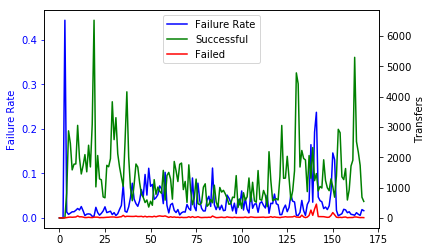

NIKHEF-ELPROD_DATADISK


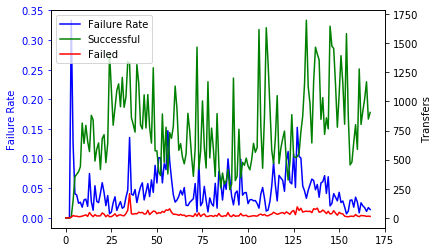

IN2P3-CC_DATADISK


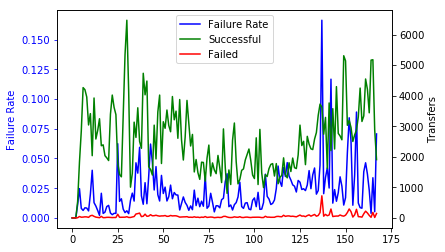

IN2P3-CC_LOCALGROUPDISK


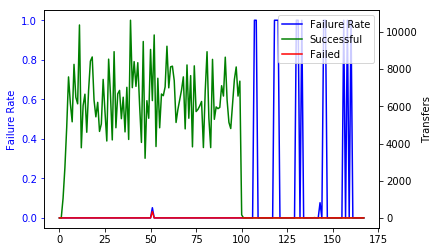

MWT2_UC_SCRATCHDISK


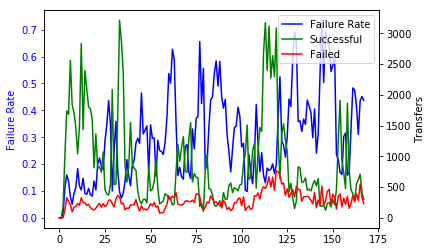

PIC_DATADISK


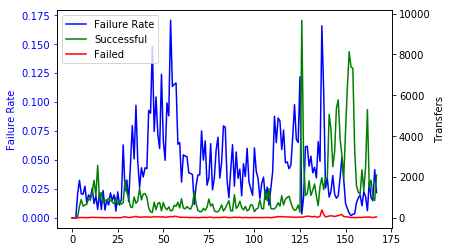

RAL-LCG2_DATADISK


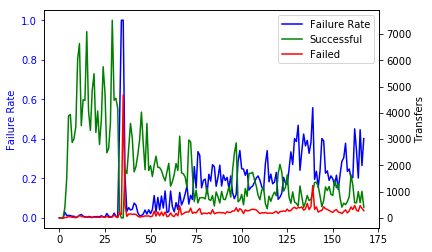

MWT2_DATADISK


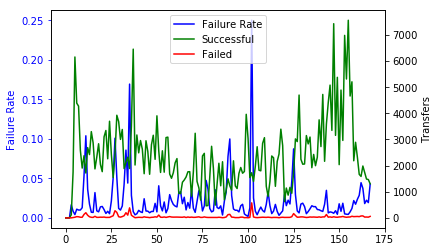

INFN-T1_DATADISK


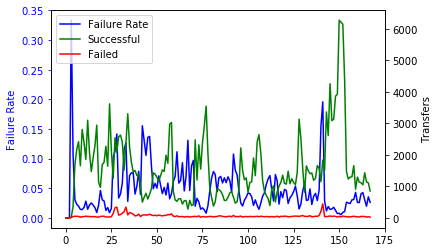

SARA-MATRIX_DATADISK


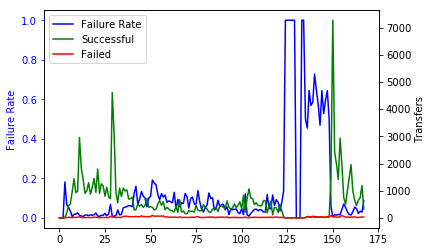

CERN-PROD_DATADISK


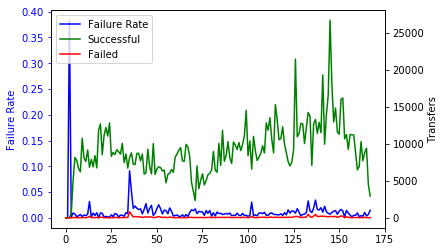

NDGF-T1_DATADISK


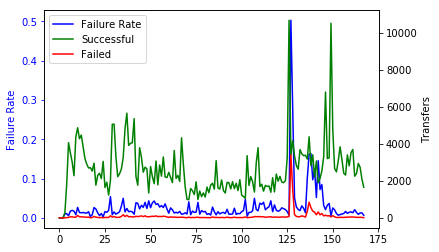

CERN-PROD_TZDISK


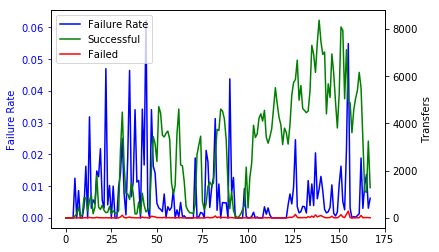

CERN-PROD_SCRATCHDISK


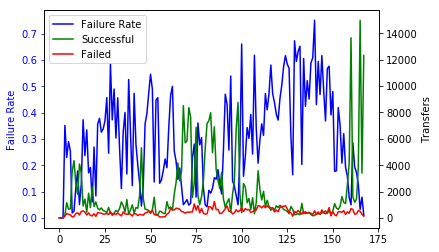

SWT2_CPB_DATADISK


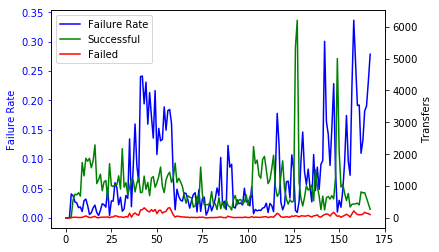

BNL-OSG2_DATADISK


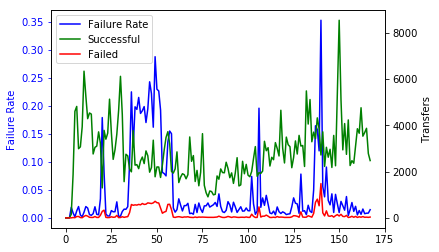

AGLT2_DATADISK


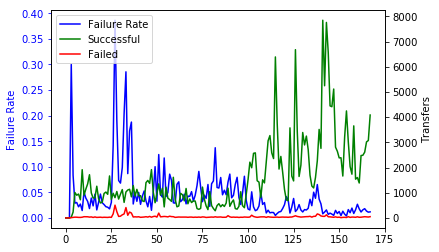

BNL-OSG2_SCRATCHDISK


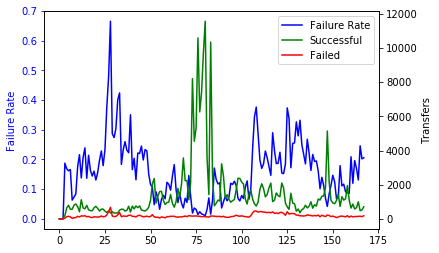

TRIUMF-LCG2_DATADISK


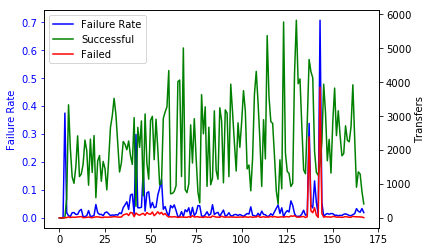

CERN-PROD-RUCIOTEST_DATADISK


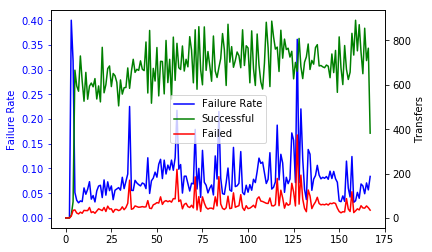

Plotting failure rates for 20 most popular destination of succesful transfers
IN2P3-CC_LOCALGROUPTAPE


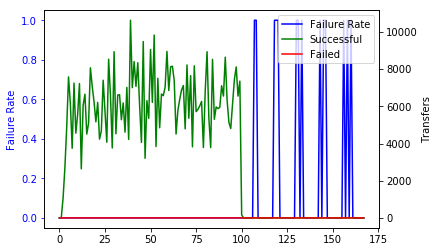

FZK-LCG2_DATADISK


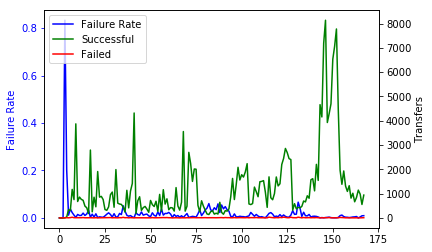

CERN-PROD_SCRATCHDISK


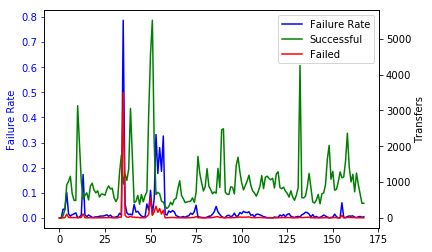

IN2P3-CC_DATADISK


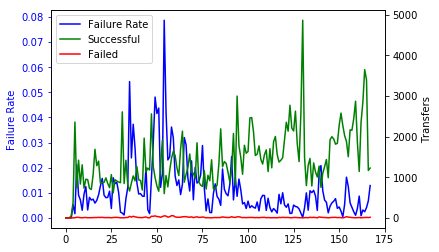

NET2_DATADISK


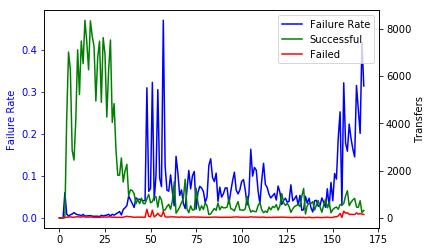

PIC_DATADISK


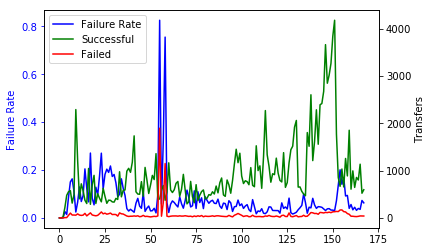

UKI-NORTHGRID-LANCS-HEP_DATADISK


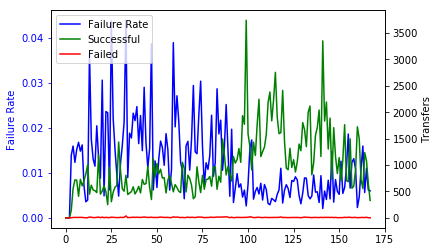

RAL-LCG2_DATADISK


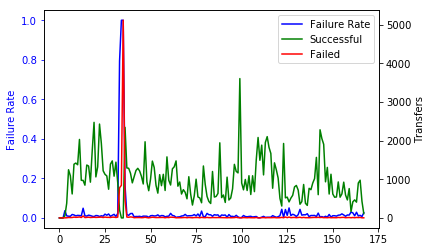

MWT2_DATADISK


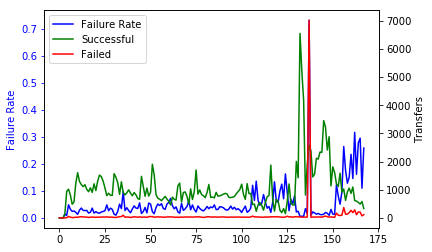

INFN-T1_DATADISK


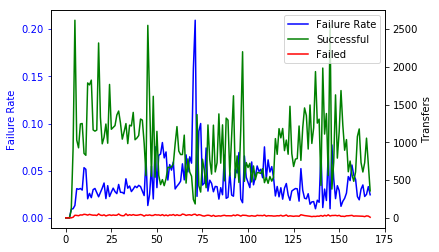

CERN-PROD_DATADISK


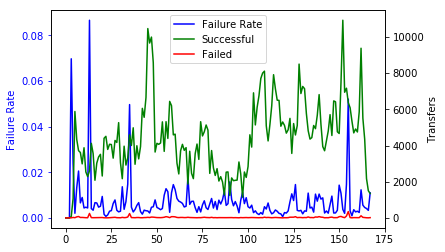

NDGF-T1_DATADISK


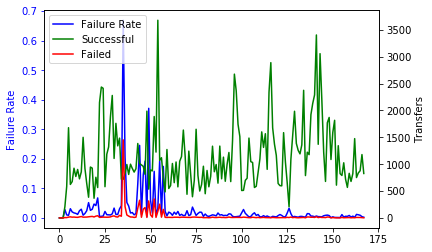

PRAGUELCG2_DATADISK


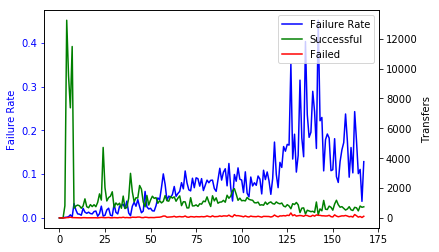

BNL-OSG2_LOCALGROUPDISK


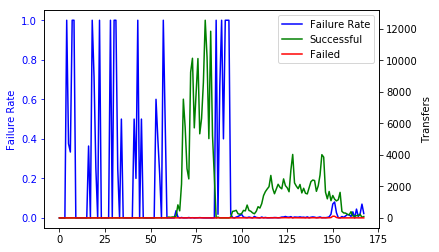

BNL-OSG2_DATADISK


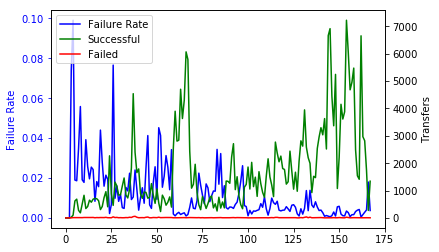

UKI-LT2-QMUL_DATADISK


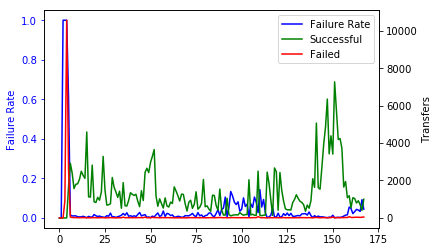

AGLT2_DATADISK


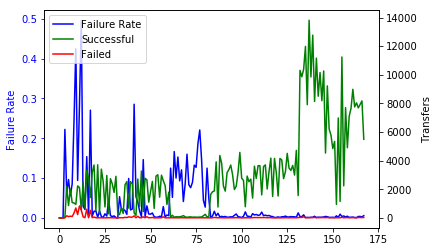

UNI-FREIBURG_DATADISK


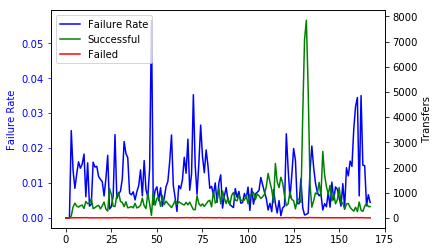

RAL-LCG2-ECHO_DATADISK


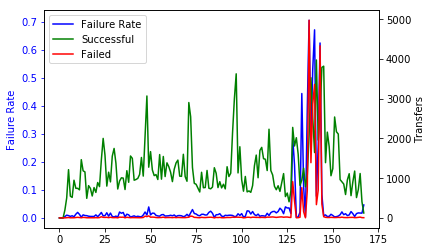

UAM-LCG2_DATADISK


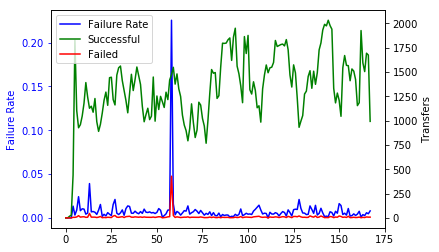

Done


In [151]:
print("Plotting")

print("Plotting failure rates for 20 most popular sources of succesful transfers")

for entry in rate_transfers_source:
    
    print(entry)
    
    fig, ax = plt.subplots()

    # Twin the x-axis to make independent y-axes. one for the rate and one for the total # of transfers
    axes = [ax, ax.twinx()]
    
    axes[0].plot(rate_transfers_source[entry], color='Blue',label='Failure Rate')
    axes[0].set_ylabel('Failure Rate', color='Blue')
    axes[0].tick_params(axis='y', colors='Blue')
    
    axes[1].plot(plot_transfers_source[entry],color='Green',label='Successful')
    axes[1].set_ylabel('Transfers', color='Black')
    axes[1].tick_params(axis='y', colors='Black')
    
    axes[1].plot(plot_transfers_source_err[entry],color='Red',label='Failed')
    
    #trickery to get all three lines on same label
    lines, labels = axes[0].get_legend_handles_labels()
    lines2, labels2 = axes[1].get_legend_handles_labels()
    plt.legend(lines + lines2, labels + labels2, loc=0)
        
    plt.show()
    

    
    
print("Plotting failure rates for 20 most popular destination of succesful transfers")

for entry in rate_transfers_dest:
    
    print(entry)
    
    fig, ax = plt.subplots()

    # Twin the x-axis to make independent y-axes. one for the rate and one for the total # of transfers
    axes = [ax, ax.twinx()]
    
    axes[0].plot(rate_transfers_dest[entry], color='Blue',label='Failure Rate')
    axes[0].set_ylabel('Failure Rate', color='Blue')
    axes[0].tick_params(axis='y', colors='Blue')
        
    axes[1].plot(plot_transfers_dest[entry],color='Green',label='Successful')
    axes[1].set_ylabel('Transfers', color='Black')
    axes[1].tick_params(axis='y', colors='Black')
    
    axes[1].plot(plot_transfers_dest_err[entry],color='Red',label='Failed')    
    
    #trickery to get all three lines on same label
    lines, labels = axes[0].get_legend_handles_labels()
    lines2, labels2 = axes[1].get_legend_handles_labels()
    plt.legend(lines + lines2, labels + labels2, loc=0)
    
    plt.show()

print("Done")

failure rate source


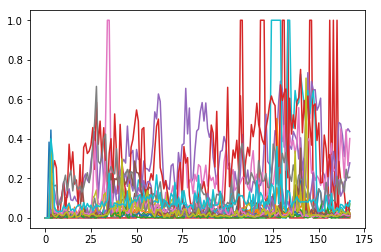

Failure rate destination


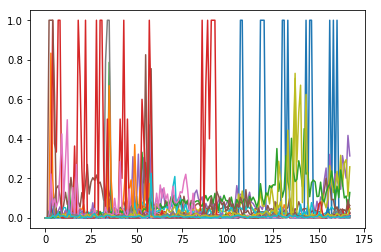

Transfers


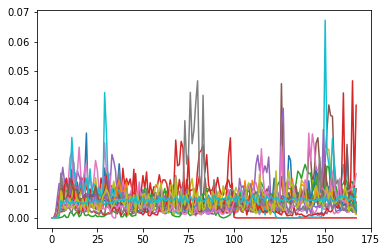

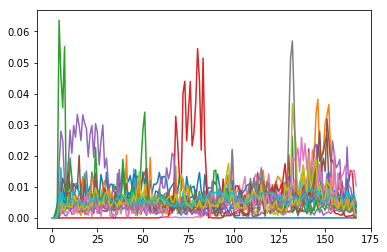

errors


'\nfor entry in plot_failures_source:\n    plt.plot(plot_failures_source[entry])\nplt.show()\nfor entry in plot_failures_dest:\n    plt.plot(plot_failures_dest[entry])\nplt.show()\n'

In [152]:
print("failure rate source")
for entry in rate_transfers_source:
    plt.plot(rate_transfers_source[entry])
plt.show()
print("Failure rate destination")
for entry in rate_transfers_dest:
    plt.plot(rate_transfers_dest[entry])
plt.show()
print("Transfers")
for entry in plot_transfers_source:
    #"normalise" lists for more comparable plotting
    plot_transfers_source[entry] = [x / sum(plot_transfers_source[entry]) for x in plot_transfers_source[entry]]
    plt.plot(plot_transfers_source[entry])
plt.show()
for entry in plot_transfers_dest:
    #"normalise" lists for more comparable plotting
    plot_transfers_dest[entry] = [x / sum(plot_transfers_dest[entry]) for x in plot_transfers_dest[entry]]
    plt.plot(plot_transfers_dest[entry])
plt.show()

"""
failures dicts are not being filled currently
print("errors")
for entry in plot_failures_source:
    plt.plot(plot_failures_source[entry])
plt.show()
for entry in plot_failures_dest:
    plt.plot(plot_failures_dest[entry])
plt.show()
"""